In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import time, json, random, math, os, sys

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
# ---------------- User knobs ----------------
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # False to exclude TARGET from X
TEST_SIZE   = 0.20
VAL_SIZE    = 0.10
RANDOM_SEED = 73
MAX_EPOCHS  = 100
VERBOSE_TRAIN = 1

# Random search settings
Z_LEVEL = 1.96
ALPHA = 0.05
ROLL_WIN = 30       # if later you want rolling PICP/MPIW
HEAT_WIN = 30
HEAT_STRIDE = 10

N_TRIALS   = 50                # bump to 40–60 for deeper search
PATIENCE   = 10
WEIGHTS_BEST = "Model Weights/rs_transformer_best.weights.h5"
MODEL_BEST   = "Model Checkpoints/transformer_rs_checkpoint.keras"

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

73


In [3]:
df = pd.read_csv(CSV_PATH)

required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


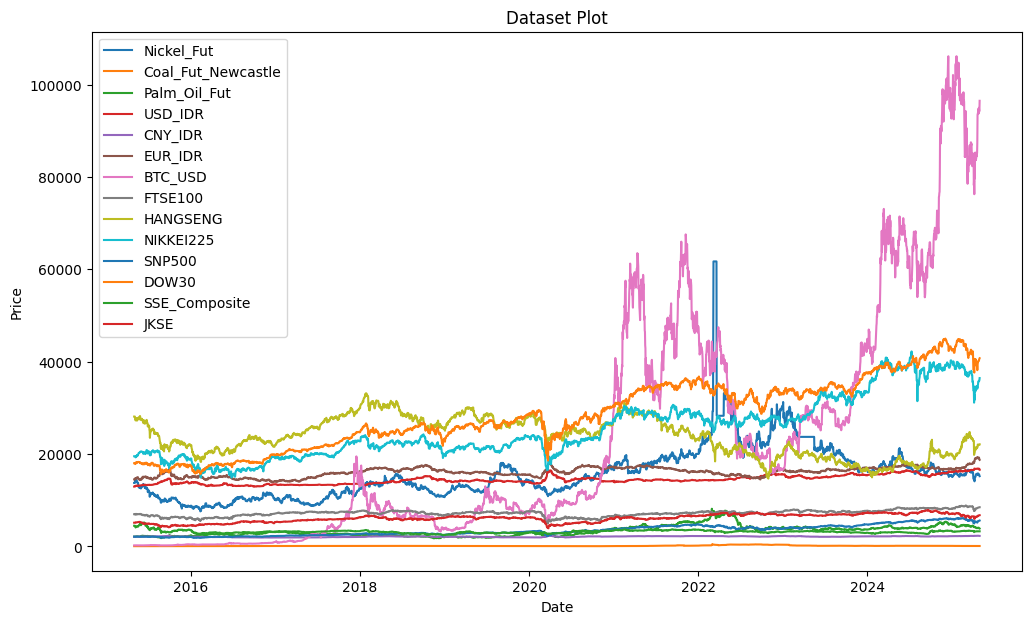

In [4]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [5]:
# ---------------- Split ----------------
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [6]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [7]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [8]:
def nll_gaussian_heteroscedastic(y_true, y_pred):
    """
    y_pred = (mu_s, log_var_s) in scaled space.
    """
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.float32)  # flatten
    mu      = y_pred[:, 0]
    log_var = tf.clip_by_value(y_pred[:, 1], -20.0, 5.0)     # stability
    inv_var = tf.exp(-log_var)
    nll = 0.5 * (log_var + (y_true - mu)**2 * inv_var)
    return tf.reduce_mean(nll)

In [9]:
# ---------------- Utilities ----------------
def make_windows(X_df, y_df, lookback: int):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index
    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])  # predict t using t-lookback..t-1
        idx_list.append(idx[i])
    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

def positional_encoding(length, depth):
    # depth must be even for sin/cos pairing
    if depth % 2 != 0: depth += 1
    positions = np.arange(length)[:, np.newaxis]
    dims = np.arange(depth)[np.newaxis, :]
    angle_rates = 1.0 / (10000 ** (2 * (dims//2) / depth))
    angle_rads = positions * angle_rates
    pe = np.zeros((length, depth), dtype=np.float32)
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(pe)

class AddPE(tf.keras.layers.Layer):
    def __init__(self, lookback, d_model, **kwargs):
        super().__init__(**kwargs)
        self.lookback = lookback
        self.d_model = d_model
        self.pos = positional_encoding(lookback, d_model)
    def call(self, x):
        return x + self.pos

def encoder_block(x, num_heads, d_model, dff, dropout_rate):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn)])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)
    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer(input_shape, params):
    lb        = params["lookback"]
    d_model   = params["d_model"]
    num_heads = params["num_heads"]
    dff       = params["dff"]
    dropout   = params["dropout"]

    inp = Input(shape=input_shape)
    x = Dense(d_model)(inp)
    x = AddPE(lb, d_model)(x)

    for _ in range(params["num_layers"]):
        x = encoder_block(
            x,
            num_heads=num_heads,
            d_model=d_model,
            dff=dff,
            dropout_rate=dropout
        )

    x = Lambda(lambda t: t[:, -1, :])(x)

    # Output heteroscedastic heads: mu_s, log_var_s
    out = Dense(2)(x)

    opt = Adam(learning_rate=params["lr"])
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=opt, loss=nll_gaussian_heteroscedastic)
    return model

# Make sure d_model is divisible by num_heads
def sample_divisible_pair(d_model_choices, head_choices):
    for _ in range(50):
        dm = random.choice(d_model_choices)
        nh = random.choice(head_choices)
        if dm % nh == 0:
            return dm, nh
    # fallback
    return 64, 4

def sample_params():
    lookback = random.choice([30, 45, 60, 90])
    d_model = random.choice([32, 64, 96, 128])
    valid_heads = [h for h in (2, 4, 8) if d_model % h == 0 and d_model // h >= 8]
    num_heads = random.choice(valid_heads)
    dff = random.choice([2*d_model, 3*d_model, 4*d_model])

    params = {
        "lookback": lookback,
        "d_model": d_model,
        "num_heads": num_heads,
        "dff": dff,
        "num_layers": random.choice([1, 2, 3]),
        "dropout": np.random.uniform(0.0, 0.3),
        "optimizer": "adam",
        "lr": 10 ** np.random.uniform(-4, math.log10(5e-3)),
        "batch_size": random.choice([32, 64, 128]),
        "epochs": random.choice([30, 40, 50, 60, 70, 80, 90, 100]),
        "patience": random.choice([5, 6, 7, 8, 9, 10])
    }

    return params

def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [10]:
# ---------------- Random Search ----------------
best = {"val_loss": np.inf, "params": None}

print("\n=== Random Search (Transformer) begins ===")
hpo_start = time.time()  # HPO timer starts
for t in range(1, N_TRIALS + 1):
    params = sample_params()

    # Build windows with this trial's lookback
    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, params["lookback"])
    X_vl, y_vl, _ = make_windows(X_val_s,   y_val_s,   params["lookback"])

    model = build_transformer((params["lookback"], len(feature_cols)), params)

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ]

    start = time.time()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_vl, y_vl),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=callbacks,
        verbose=0
    )
    dur = time.time() - start

    val_loss = float(min(hist.history["val_loss"]))
    print(f"[Trial {t:02d}] lb={params['lookback']}, layers={params['num_layers']}, "
          f"d_model={params['d_model']}, heads={params['num_heads']}, dff={params['dff']}, "
          f"drop={params['dropout']}, opt={params['optimizer']}, lr={params['lr']}, "
          f"bs={params['batch_size']}  => val_loss={val_loss:.6f} ({dur:.1f}s)")

    if val_loss < best["val_loss"]:
        best = {"val_loss": val_loss, "params": params}
        model.save_weights(WEIGHTS_BEST)
hpo_end = time.time()  # HPO timer ends
hpo_time_s = float(hpo_end - hpo_start)
hpo_trials = N_TRIALS

print("\nBest val_loss:", best["val_loss"])
print("Best params:\n", json.dumps(best["params"], indent=2))


=== Random Search (Transformer) begins ===

[Trial 01] lb=60, layers=1, d_model=32, heads=4, dff=128, drop=0.1928069747358237, opt=adam, lr=0.0008224335253611052, bs=64  => val_loss=-1.857629 (32.4s)
[Trial 02] lb=30, layers=2, d_model=128, heads=4, dff=512, drop=0.15356939473758902, opt=adam, lr=0.001088450601734486, bs=64  => val_loss=-1.765048 (73.4s)
[Trial 03] lb=60, layers=1, d_model=96, heads=8, dff=192, drop=0.1478966950833575, opt=adam, lr=0.0002314006109844354, bs=128  => val_loss=-1.860471 (80.2s)
[Trial 04] lb=90, layers=1, d_model=128, heads=8, dff=512, drop=0.07319400578627434, opt=adam, lr=0.0009375003516099346, bs=64  => val_loss=-2.017994 (159.3s)
[Trial 05] lb=90, layers=1, d_model=64, heads=4, dff=192, drop=0.23178859911751776, opt=adam, lr=0.0003370913223832548, bs=32  => val_loss=-1.761940 (50.9s)
[Trial 06] lb=30, layers=2, d_model=32, heads=4, dff=128, drop=0.12122495231776917, opt=adam, lr=0.0010326315261003302, bs=128  => val_loss=-1.543332 (18.2s)
[Trial 07] 

In [11]:
# ---------------- Retrain best on TRAIN+VAL & Evaluate on TEST ----------------
lb = best["params"]["lookback"]
X_trainval_s = pd.concat([X_train_s, X_val_s], axis=0)
y_trainval_s = pd.concat([y_train_s, y_val_s], axis=0)

X_trv, y_trv, _ = make_windows(X_trainval_s, y_trainval_s, lb)
X_te,  y_te,  idx_te  = make_windows(X_test_s,      y_test_s,      lb)

best_model = build_transformer((lb, len(feature_cols)), best["params"])

callbacks_final = [
    EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(MODEL_BEST, monitor="val_loss", save_best_only=True),
    # ModelCheckpoint(WEIGHTS_BEST, monitor="val_loss", save_best_only=True, save_weights_only=True),
]

start_train = time.time()
hist_final = best_model.fit(
    X_trv, y_trv,
    validation_split=0.1,
    epochs=best["params"]["epochs"],
    batch_size=best["params"]["batch_size"],
    callbacks=callbacks_final,
    verbose=VERBOSE_TRAIN
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.2f} s")

Epoch 1/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 1.5755 - val_loss: -0.1548
Epoch 2/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: -0.6059 - val_loss: -1.0470
Epoch 3/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: -0.9685 - val_loss: -1.3542
Epoch 4/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: -1.2036 - val_loss: -1.2285
Epoch 5/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: -1.2388 - val_loss: -0.7544
Epoch 6/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: -1.1536 - val_loss: -1.6943
Epoch 7/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: -1.5728 - val_loss: -1.5630
Epoch 8/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: -1.6153 - val_loss: -1.2266
Epoch 9/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: -1.6938 - val_loss: -1.6840
Epoch 10/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: -1.7696 - val_loss: -1.4285
Epoch 11/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: -1.7367 - val_loss: -1.7361
Epoch 12/70
40/40 ━━━━━━━━━━━━━

In [12]:
# Heteroscedastic Prediction (mu, sigma_ale)
start_test = time.time()
yhat_s = best_model.predict(X_te, verbose=1)  # (N, 2)

mu_s      = yhat_s[:, 0]
log_var_s = yhat_s[:, 1]

# scale back to original
y_mean = y_scaler.mean_[0]
y_std  = y_scaler.scale_[0]

mu_orig = mu_s * y_std + y_mean
var_orig = np.exp(log_var_s) * (y_std ** 2)
sigma_ale = np.sqrt(var_orig)

pred_test = pd.DataFrame({
    "mu": mu_orig,
    "sigma_ale": sigma_ale
}, index=idx_te)

end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} s")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing (inference) time: 0.5120 s


In [13]:
def predict_hetero(model, X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=0)
    mu_s      = yhat_s[:, 0]
    log_var_s = yhat_s[:, 1]

    y_mean = y_scaler.mean_[0]
    y_std  = y_scaler.scale_[0]

    mu_orig = mu_s * y_std + y_mean
    var_orig = np.exp(log_var_s) * (y_std ** 2)
    sigma_ale = np.sqrt(var_orig)

    return pd.DataFrame({
        "mu": mu_orig,
        "sigma_ale": sigma_ale
    }, index=idx_block)


# Build windows for TRAIN and VAL
X_tr, y_tr, idx_tr = make_windows(X_train_s, y_train_s, lb)
X_vl, y_vl, idx_vl = make_windows(X_val_s,   y_val_s,   lb)

pred_train = predict_hetero(best_model, X_tr, idx_tr)
pred_val   = predict_hetero(best_model, X_vl, idx_vl)

In [14]:
# Last-Layer Laplace Approximation (LLLA) — Transformer
# Penultimate layer = layers[-2]
penultimate_layer = best_model.layers[-2]

phi_model = tf.keras.Model(
    inputs=best_model.inputs[0],
    outputs=penultimate_layer.output
)

phi_train = phi_model.predict(X_tr, verbose=0)
phi_val   = phi_model.predict(X_vl, verbose=0)
phi_test  = phi_model.predict(X_te, verbose=0)

phi_trainval = phi_model.predict(X_trv, verbose=0)   # keep for sigma_n2

print("phi_trainval:", phi_trainval.shape)
print("phi_test:", phi_test.shape)

phi_trainval: (2834, 128)
phi_test: (640, 128)


In [15]:
# scaled-space mu for train/val
yhat_trainval_s = best_model.predict(X_trv, verbose=0)
mu_trainval_s   = yhat_trainval_s[:, 0]

y_trainval_s_flat = y_trv.squeeze()

residuals_s = y_trainval_s_flat - mu_trainval_s
sigma_n2 = np.mean(residuals_s ** 2)
print("Estimated noise variance (scaled):", sigma_n2)

Estimated noise variance (scaled): 0.004564378


In [16]:
N_tr, H = phi_trainval.shape

Phi_tr = np.concatenate([phi_trainval, np.ones((N_tr,1))], axis=1)
lambda_prior = 1.0

H_diag = (1.0 / sigma_n2) * np.sum(Phi_tr**2, axis=0) + lambda_prior
var_w_diag = 1.0 / H_diag

In [17]:
def compute_sigma_epi(phi_block, idx_block):
    N, H = phi_block.shape
    Phi_b = np.concatenate([phi_block, np.ones((N,1))], axis=1)
    var_epi_scaled = np.sum((Phi_b**2) * var_w_diag.reshape(1,-1), axis=1)
    var_epi_orig   = var_epi_scaled * (y_scaler.scale_[0] ** 2)
    return pd.Series(np.sqrt(np.maximum(var_epi_orig, 1e-12)), index=idx_block)

sigma_epi_train = compute_sigma_epi(phi_train, idx_tr)
sigma_epi_val   = compute_sigma_epi(phi_val,   idx_vl)
sigma_epi_test  = compute_sigma_epi(phi_test,  idx_te)

In [18]:
# TRAIN
pred_train["sigma_epi"] = sigma_epi_train
pred_train["sigma_total"] = np.sqrt(pred_train["sigma_ale"]**2 + pred_train["sigma_epi"]**2)

# VAL
pred_val["sigma_epi"] = sigma_epi_val
pred_val["sigma_total"] = np.sqrt(pred_val["sigma_ale"]**2 + pred_val["sigma_epi"]**2)

# TEST
pred_test["sigma_epi"] = sigma_epi_test
pred_test["sigma_total"] = np.sqrt(pred_test["sigma_ale"]**2 + pred_test["sigma_epi"]**2)

pred_test.head()

,mu,sigma_ale,sigma_epi,sigma_total
2023-08-01,6720.954590,59.980934,10.368399,60.870486
2023-08-02,6679.301270,60.219460,10.380476,61.107590
2023-08-03,6667.025391,60.665031,10.381813,61.546959
2023-08-04,6708.244629,60.307449,10.377798,61.193849
2023-08-05,6676.910156,60.449642,10.354862,61.330110


In [19]:
actual = df[TARGET_COL]
actual_train = actual.loc[idx_tr]
actual_val   = actual.loc[idx_vl]
actual_test  = actual.loc[idx_te]

In [20]:
actual = df[TARGET_COL]
actual_test = actual.loc[idx_te]

metrics_train = compute_metrics(actual_train.values, pred_train["mu"].values)
metrics_val   = compute_metrics(actual_val.values,   pred_val["mu"].values)
metrics_test  = compute_metrics(actual_test.values,  pred_test["mu"].values)

metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE","MAE","RMSE","MAPE","R²"],
    index=["Train", "Val", "Test"]
)

print("\n=== Metrics (Transformer — HLLLA) ===")
print(metrics_df)


=== Metrics (Transformer — HLLLA) ===
                 MSE         MAE        RMSE      MAPE        R²
Train    2035.692221   31.239278   45.118646  0.005558  0.995907
Val      3873.890457   51.407471   62.240585  0.007475  0.744843
Test   188250.169336  405.958654  433.878058  0.056382 -0.692086


In [21]:
def compute_pi_metrics_from_sigma(y_true, mu, sigma, z_level=1.96, alpha=0.05):
    """
    Compute PICP, MPIW, Winkler Score from μ and σ_total.
    y_true, mu, sigma must be original-scale arrays.
    """
    y_true = np.asarray(y_true, dtype=float)
    mu     = np.asarray(mu, dtype=float)
    sigma  = np.asarray(sigma, dtype=float)

    # 1) Interval
    L = mu - z_level * sigma
    U = mu + z_level * sigma

    # 2) Coverage
    inside = (y_true >= L) & (y_true <= U)
    picp = inside.mean()

    # 3) Width
    width = U - L
    mpiw = width.mean()

    # 4) Winkler score
    penalties = np.zeros_like(y_true)

    below = y_true < L
    above = y_true > U

    penalties[below] = (L[below] - y_true[below])
    penalties[above] = (y_true[above] - U[above])

    winkler = np.mean(width + (2.0 / alpha) * penalties)

    return picp, mpiw, winkler

trans_picp_train, trans_mpiw_train, trans_wink_train = compute_pi_metrics_from_sigma(
    actual_train.values,
    pred_train["mu"].values,
    pred_train["sigma_total"].values,
    z_level=Z_LEVEL,
    alpha=ALPHA
)

trans_picp_val, trans_mpiw_val, trans_wink_val = compute_pi_metrics_from_sigma(
    actual_val.values,
    pred_val["mu"].values,
    pred_val["sigma_total"].values,
    z_level=Z_LEVEL,
    alpha=ALPHA
)

trans_picp_test, trans_mpiw_test, trans_wink_test = compute_pi_metrics_from_sigma(
    actual_test.values,
    pred_test["mu"].values,
    pred_test["sigma_total"].values,
    z_level=Z_LEVEL,
    alpha=ALPHA
)

print("\n=== UQ Interval Metrics (Transformer — Heteroscedastic + LLLA) ===")
print(f"TRAIN — PICP: {trans_picp_train:.4f} | MPIW: {trans_mpiw_train:.4f} | Winkler: {trans_wink_train:.4f}")
print(f"VAL   — PICP: {trans_picp_val:.4f} | MPIW: {trans_mpiw_val:.4f} | Winkler: {trans_wink_val:.4f}")
print(f"TEST  — PICP: {trans_picp_test:.4f} | MPIW: {trans_mpiw_test:.4f} | Winkler: {trans_wink_test:.4f}")


=== UQ Interval Metrics (Transformer — Heteroscedastic + LLLA) ===
TRAIN — PICP: 0.9788 | MPIW: 240.2392 | Winkler: 266.4158
VAL   — PICP: 0.9851 | MPIW: 301.4283 | Winkler: 311.5710
TEST  — PICP: 0.0219 | MPIW: 262.0119 | Winkler: 11311.6482


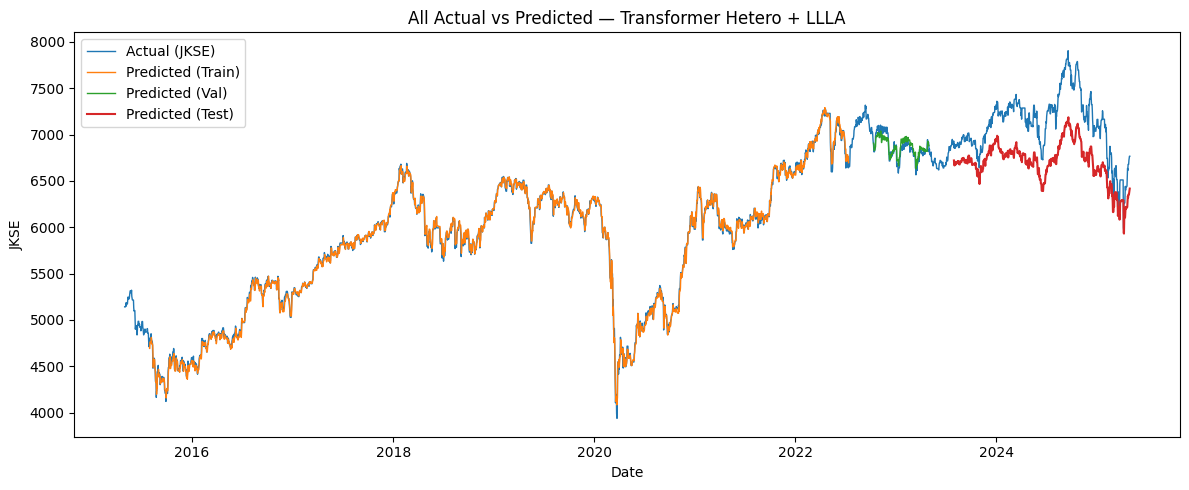

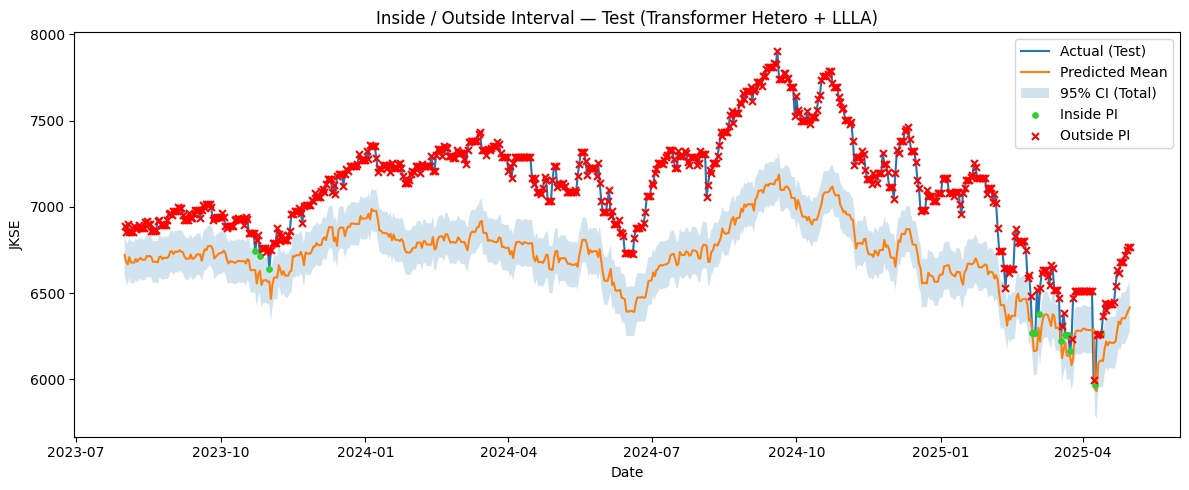

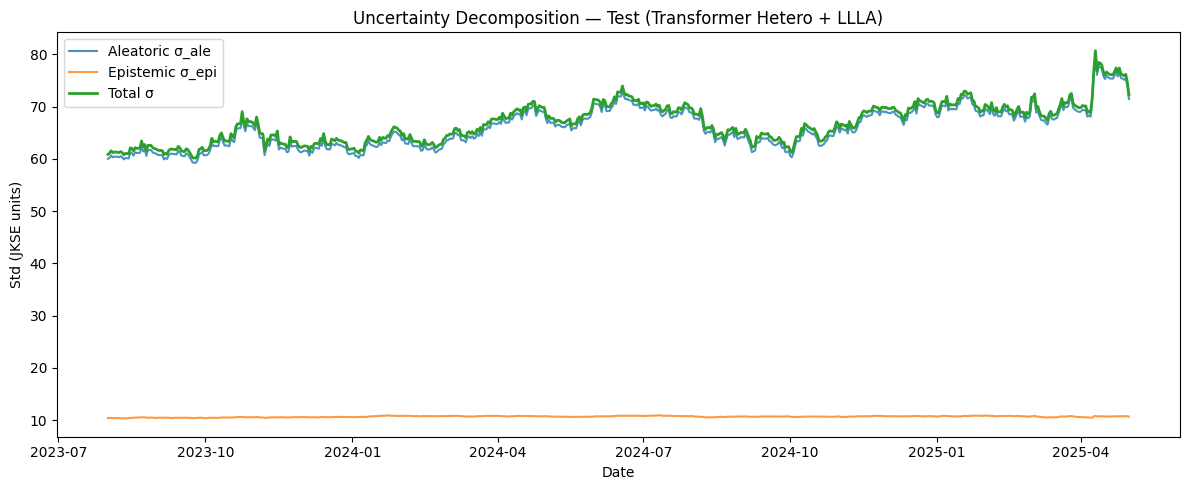

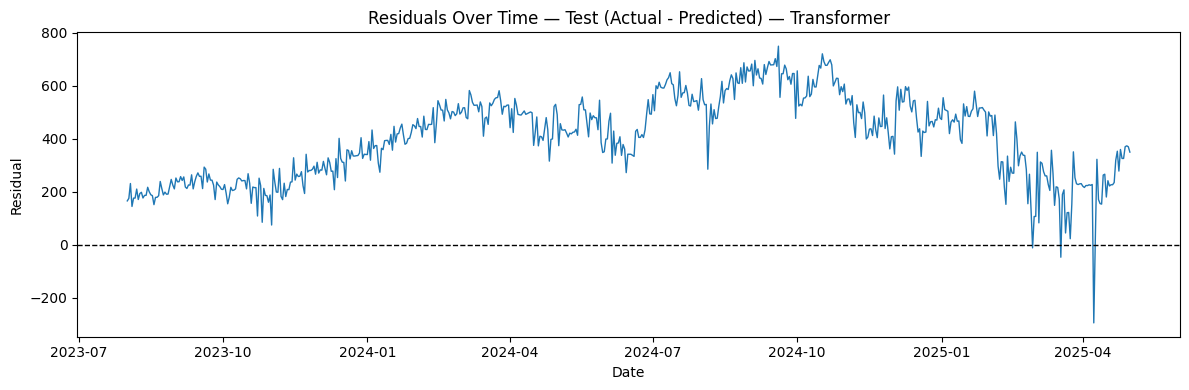

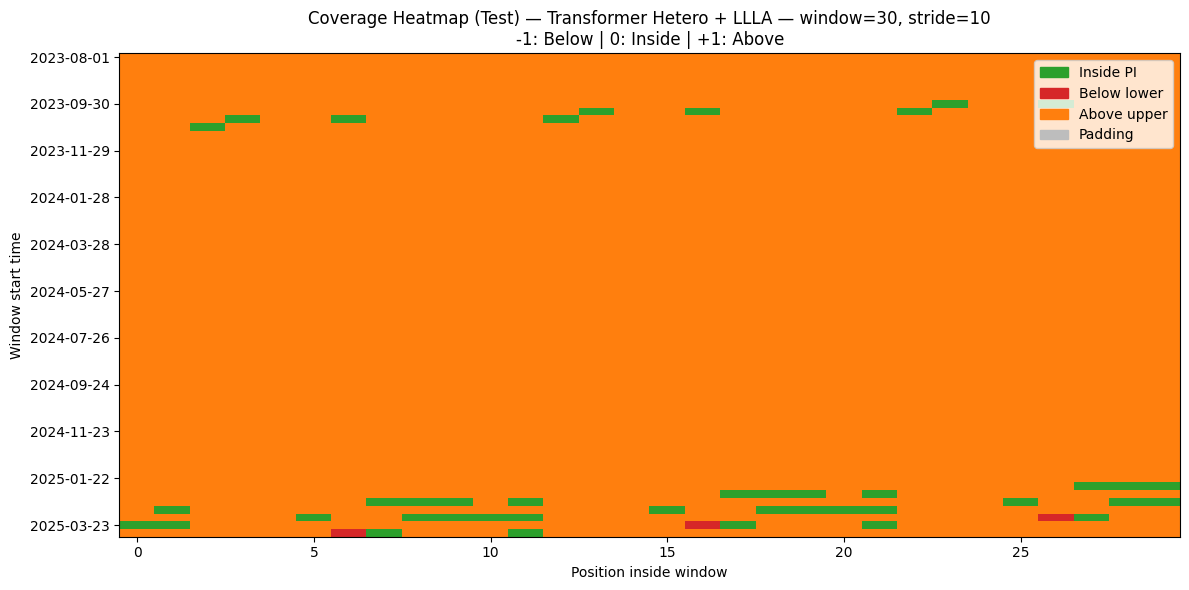

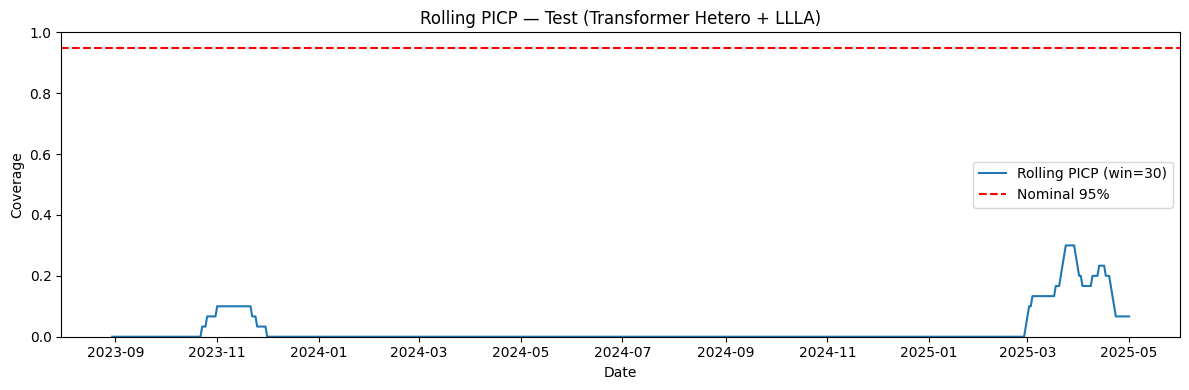

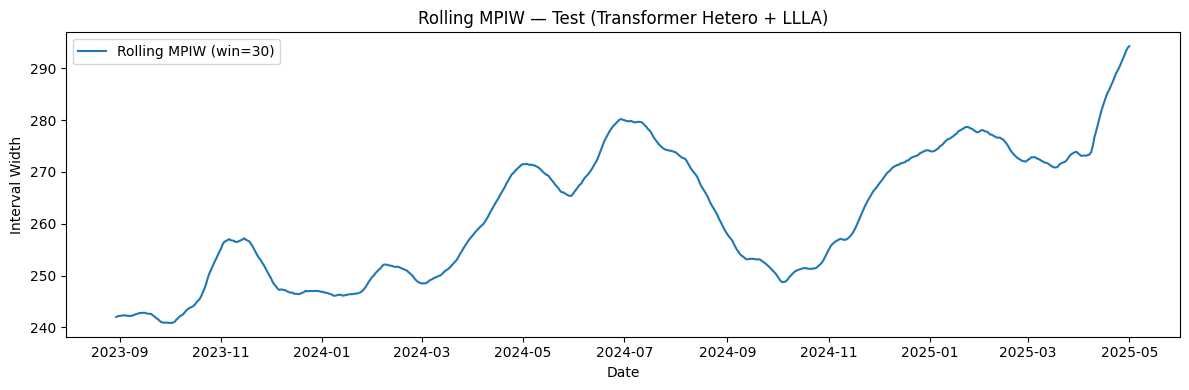

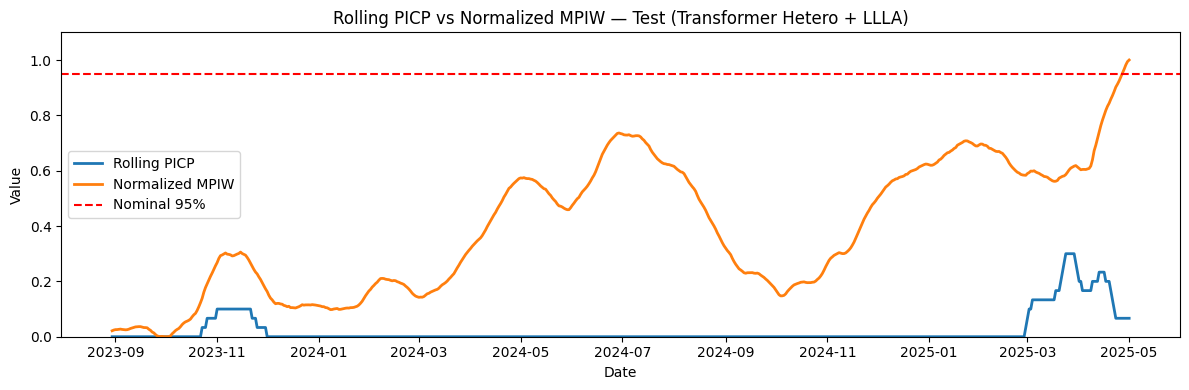

In [22]:
# Convenience aliases
mu_train = pred_train["mu"]
mu_val   = pred_val["mu"]
mu_test  = pred_test["mu"]

sigma_ale_train = pred_train["sigma_ale"]
sigma_ale_val   = pred_val["sigma_ale"]
sigma_ale_test  = pred_test["sigma_ale"]

sigma_epi_train  = pred_train["sigma_epi"]
sigma_epi_val    = pred_val["sigma_epi"]
sigma_epi_test   = pred_test["sigma_epi"]

sigma_total_train = pred_train["sigma_total"]
sigma_total_val   = pred_val["sigma_total"]
sigma_total_test  = pred_test["sigma_total"]

# Build total intervals for test set
L_test = mu_test - Z_LEVEL * sigma_total_test
U_test = mu_test + Z_LEVEL * sigma_total_test

# (1) ALL ACTUAL vs PREDICTED (Train / Val / Test)
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(mu_train.index, mu_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(mu_val.index,   mu_val.values,   label="Predicted (Val)", linewidth=1)
plt.plot(mu_test.index,  mu_test.values,  label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs Predicted — Transformer Hetero + LLLA")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (2) INSIDE (GREEN) / OUTSIDE (RED) — TEST ONLY
y_true_test = actual_test

inside_mask = (y_true_test >= L_test) & (y_true_test <= U_test)
outside_mask = ~inside_mask

plt.figure(figsize=(12, 5))
plt.plot(y_true_test.index, y_true_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mu_test.index, mu_test.values, label="Predicted Mean", linewidth=1.5)
plt.fill_between(mu_test.index, L_test.values, U_test.values, alpha=0.2, label="95% CI (Total)")
plt.scatter(y_true_test.index[inside_mask], y_true_test.values[inside_mask], s=15, label="Inside PI", zorder=3, color="limegreen")
plt.scatter(y_true_test.index[outside_mask], y_true_test.values[outside_mask], s=25, marker="x", label="Outside PI", zorder=3, color="red")
plt.title("Inside / Outside Interval — Test (Transformer Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (3) UNCERTAINTY DECOMPOSITION — TEST
plt.figure(figsize=(12, 5))
plt.plot(sigma_ale_test.index,   sigma_ale_test.values,   label="Aleatoric σ_ale", alpha=0.8)
plt.plot(sigma_epi_test.index,   sigma_epi_test.values,   label="Epistemic σ_epi", alpha=0.8)
plt.plot(sigma_total_test.index, sigma_total_test.values, label="Total σ", linewidth=2)
plt.title("Uncertainty Decomposition — Test (Transformer Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Std (JKSE units)")
plt.legend(); plt.tight_layout(); plt.show()

# (4) RESIDUALS OVER TIME — TEST
residuals_test = y_true_test.values - mu_test.values

plt.figure(figsize=(12, 4))
plt.plot(y_true_test.index, residuals_test, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1, color="black")
plt.title("Residuals Over Time — Test (Actual - Predicted) — Transformer")
plt.xlabel("Date"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# (5) COVERAGE HEATMAP (PER-WINDOW) — TEST
y_true = y_true_test.values
L_arr  = L_test.values
U_arr  = U_test.values

below_mask  = (y_true < L_arr)
above_mask  = (y_true > U_arr)
inside_mask = (y_true >= L_arr) & (y_true <= U_arr)

status = np.zeros_like(y_true, dtype=float)
status[below_mask] = -1
status[above_mask] = 1

starts = np.arange(0, len(status) - HEAT_WIN + 1, HEAT_STRIDE)
if len(starts) == 0:
    starts = np.array([0])
    HEAT_WIN = len(status)

mat = []
x_tick_labels = []

for s in starts:
    e = min(s + HEAT_WIN, len(status))
    row = status[s:e]
    if e - s < HEAT_WIN:
        row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row)
    x_tick_labels.append(y_true_test.index[s].strftime("%Y-%m-%d"))

mat = np.vstack(mat)

cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(12, 6))
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — Transformer Hetero + LLLA — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window")
plt.ylabel("Window start time")

yticks = np.arange(0, len(starts), max(1, len(starts) // 10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])

legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding"),
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

# (6) ROLLING PICP — TEST (Total intervals)
covered = ((y_true_test >= L_test) & (y_true_test <= U_test)).astype(int)
rolling_picp = covered.rolling(ROLL_WIN).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, label=f"Rolling PICP (win={ROLL_WIN})")
plt.axhline(0.95, color="red", linestyle="--", label="Nominal 95%")
plt.title("Rolling PICP — Test (Transformer Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Coverage")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout(); plt.show()

# (7) ROLLING MPIW — TEST (Total intervals)
width = (U_test - L_test)
rolling_mpiw = width.rolling(ROLL_WIN).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, label=f"Rolling MPIW (win={ROLL_WIN})")
plt.title("Rolling MPIW — Test (Transformer Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Interval Width")
plt.legend()
plt.tight_layout(); plt.show()

# (8) ROLLING PICP + NORMALIZED MPIW — TEST
mpiwn = (rolling_mpiw - rolling_mpiw.min()) / (rolling_mpiw.max() - rolling_mpiw.min() + 1e-12)

plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, label="Rolling PICP", linewidth=2)
plt.plot(mpiwn.index, mpiwn.values, label="Normalized MPIW", linewidth=2)
plt.axhline(0.95, color="red", linestyle="--", label="Nominal 95%")
plt.title("Rolling PICP vs Normalized MPIW — Test (Transformer Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Value")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout(); plt.show()

In [23]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_UQ_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_UQ_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "transformer_hllla"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(mu_test.values, index=pd.to_datetime(idx_te), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Create lower and upper bound series (aligned to date)
L_series = pd.Series(L_test.values, index=pd.to_datetime(idx_te), name=f"{model_name}_L")
U_series = pd.Series(U_test.values, index=pd.to_datetime(idx_te), name=f"{model_name}_U")
L_series = L_series.reindex(all_pred_df["date"])  # align by date
U_series = U_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values
all_pred_df[f"{model_name}_L"] = L_series.values  # Add lower bound
all_pred_df[f"{model_name}_U"] = U_series.values  # Add upper bound

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = compute_metrics(actual_test.values, mu_test.values)
picp, mpiw, winkler = compute_pi_metrics_from_sigma(actual_test.values, L_test.values, U_test.values, ALPHA)

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(hpo_end - hpo_start, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: transformer_hllla_73
✅ Predictions saved to ..\Results\ALL_UQ_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_UQ_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
